## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib
from shapely.geometry import mapping

import cartopy
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Open DMSP-Light Data

In [3]:
dmsp_2000 = rioxarray.open_rasterio(r'data/dmsp/dmsp_2000_clip_istanbul.tif').squeeze()
dmsp_2013 = rioxarray.open_rasterio(r'data/dmsp/dmsp_2013_clip_istanbul.tif').squeeze()

## 2. Open Corine Data

In [4]:
def assign_nodata(dt):
    
    # nodata to np.nan
    dt = xr.where(dt==0, np.nan, dt)

    # write nodata
    dt = dt.rio.write_nodata(np.nan)
    return dt

In [5]:
def define_index_correspondence():
    indexes = {
        'urban' : np.arange(1, 12), # 1 to 11 included
        'agriculture' : np.arange(12, 23), # 12 to 22 included
        'forest' : np.arange(23, 35), # 23 to 34 included
        'wetlands' : np.arange(35, 40), # 35 to 39 included
        'water' : np.arange(40, 46), # 40 to 45 included
        'all': np.arange(1, 46), # all grids
        'all_but_water': np.arange(1, 40) # all but not water
    }
    
    return indexes

# define land-use index correspondence of name
indexes = define_index_correspondence()

index = 'urban'

In [6]:
corine_2000 = rioxarray.open_rasterio(r'data/corine/corine_2000_clipped_istanbul.tif').squeeze()
corine_2018 = rioxarray.open_rasterio(r'data/corine/corine_2018_clipped_istanbul.tif').squeeze()

In [7]:
# reproject
corine_2000 = corine_2000.rio.reproject(4326)
corine_2018 = corine_2018.rio.reproject(4326)

In [8]:
corine_2000 = corine_2000.where(corine_2000.isin(indexes[index]), -1)
corine_2000 = corine_2000.where(corine_2000==-1, 0)

# nodata to np.nan
corine_2000 = xr.where(corine_2000==-1, np.nan, corine_2000)
corine_2000 = corine_2000.rio.write_nodata(np.nan)

In [9]:
corine_2018 = corine_2018.where(corine_2018.isin(indexes[index]), -1)
corine_2018 = corine_2018.where(corine_2018==-1, 0)

# nodata to np.nan
corine_2018 = xr.where(corine_2018==-1, np.nan, corine_2018)
corine_2018 = corine_2018.rio.write_nodata(np.nan)

## 3. Visualization

In [10]:
# Parameters to change (plot) -------------------
# projection
lcc = cartopy.crs.Mercator()

# fig features
fig_array = [[1, 2],
             [3, 4]
            ]
graphic_no = 4

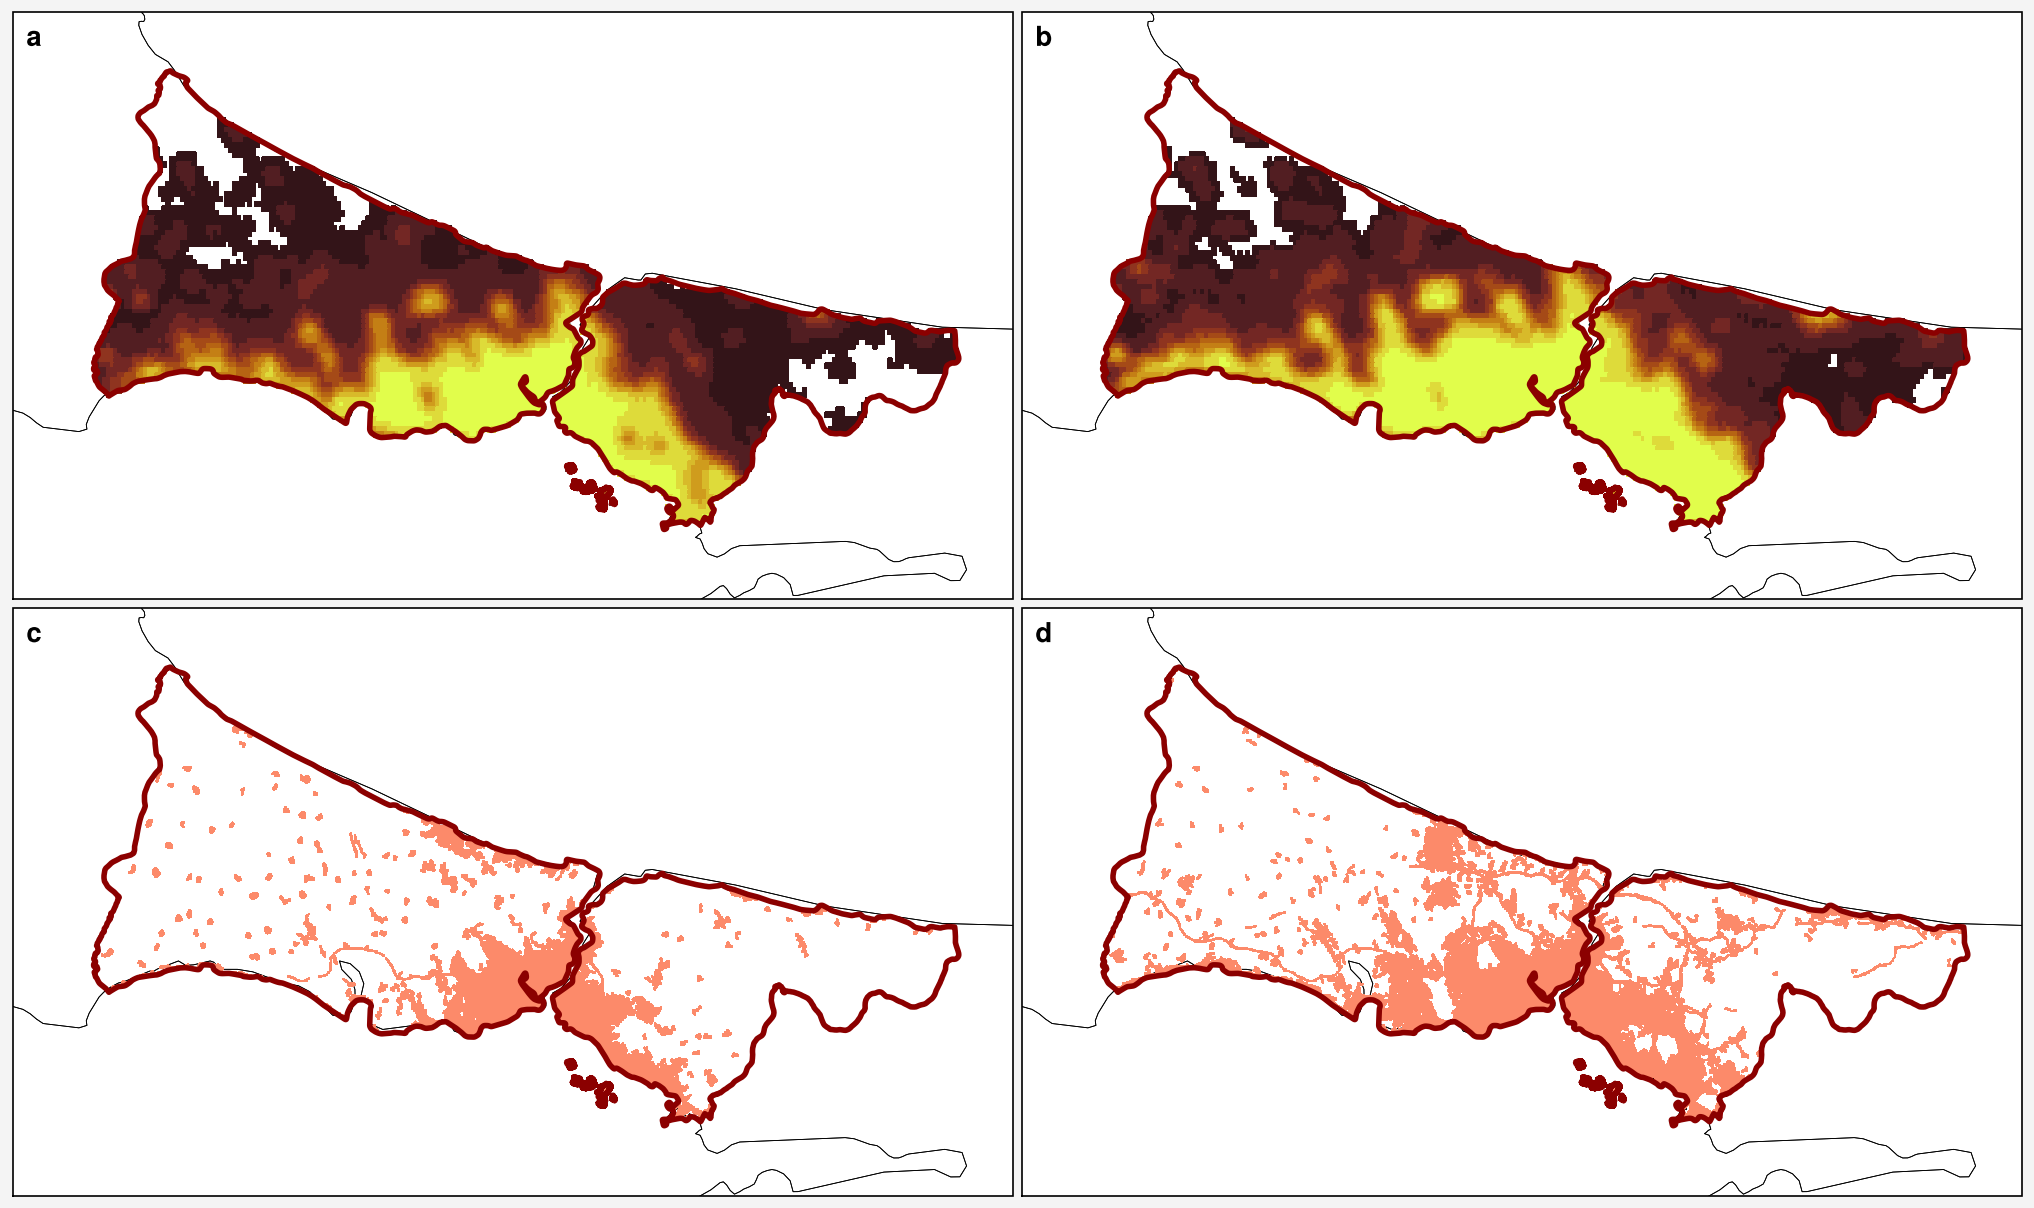

In [11]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=[lcc, lcc, lcc, lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc=True,
           zorder=50)

# istanbul limits
for i in range(4):
    axs[i].format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
               longrid=False, 
               latgrid = False)
    
# shapefile
# add shapefiles to figure
    
# İstanbul - province
istanbul_shape = fr'data/shapefiles/istanbul_province_borders.shp'

shape_feature_istanbul = ShapelyFeature(shpreader.Reader(istanbul_shape).geometries(),
                                      cartopy.crs.PlateCarree(), 
                                      facecolor='none', edgecolor = 'darkred',
                                      linewidth = 2, zorder = 50)

# add shapefiles as a feature
axs[0].add_feature(shape_feature_istanbul)
axs[1].add_feature(shape_feature_istanbul)
axs[2].add_feature(shape_feature_istanbul)
axs[3].add_feature(shape_feature_istanbul)

# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

# external countries (shapefiles will be defined for these)
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia',
       'Cyprus', 'Northern Cyprus',
       ]
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(4):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='white', edgecolor = 'black',
                              linewidth = 0.1, zorder = 9.5,)
                
                
    elif country.attributes['ADMIN'] == 'Turkey':
        
        tr = country.geometry
        for i in range(4):
            axs[i].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.3,
                              facecolor='white', zorder=2)
            axs[i].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.3,
                              facecolor='none', zorder=30)
    
    elif country.attributes['ADMIN'] == 'Bulgaria' or \
         country.attributes['ADMIN'] == 'Greece' or \
         country.attributes['ADMIN'] == 'Romania':
        
        count_shp = country.geometry
        for i in range(4):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='white', edgecolor = 'black',
                              linewidth = 0.1, zorder = 2.2,)
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.1,
                              facecolor='none', zorder=30)
            
# dmsp data
# cmap
cmap_dmsp = proplot.Colormap('Solar')

axs[0].pcolormesh(dmsp_2000['x'].values, dmsp_2000['y'].values,
                  assign_nodata(dmsp_2000), cmap=cmap_dmsp, 
                  transform=cartopy.crs.PlateCarree(),
                  zorder=40,)

axs[1].pcolormesh(dmsp_2013['x'].values, dmsp_2013['y'].values,
                  assign_nodata(dmsp_2013), cmap=cmap_dmsp, 
                  transform=cartopy.crs.PlateCarree(),
                  zorder=40,)

# corine data
# cmap
cmap_corine = 'Reds'

axs[2].pcolormesh(corine_2000['x'].values,
                  corine_2000['y'].values,
                  corine_2000, cmap=cmap_corine,
                  transform=cartopy.crs.PlateCarree(),
                  zorder=40,)

axs[3].pcolormesh(corine_2018['x'].values,
                  corine_2018['y'].values,
                  corine_2018, cmap=cmap_corine,
                  transform=cartopy.crs.PlateCarree(),
                  zorder=40,)

#save figure
plt.savefig(r'pictures/light_landuse_change_2000_2013_2018.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)